<a href="https://colab.research.google.com/github/zeeba-tech/data-science/blob/main/stable_diffusion(diffusionedit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup & Imports




In [1]:
pip install --upgrade diffusers transformers scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 304 kB 6.7 MB/s 
     |████████████████████████████████| 5.5 MB 7.3 MB/s 
     |████████████████████████████████| 163 kB 33.4 MB/s 
     |████████████████████████████████| 7.6 MB 12.1 MB/s 


In [2]:
!pip install -q --upgrade transformers diffusers ftfy

     |████████████████████████████████| 53 kB 1.4 MB/s 


In [3]:
!pip install diffusers[torch]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 148 kB 7.5 MB/s 


In [4]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import torch, logging
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler, DDIMScheduler
from diffusers import StableDiffusionInpaintPipeline
#import PIL
from PIL import Image
from pathlib import Path
from fastdownload import FastDownload
from torchvision import transforms as tfms
import numpy as np
import cv2

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import display

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()
logging.disable(logging.WARNING) ## ignore warnings
%matplotlib inline

In [ ]:
def load_artifacts():
    vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")
    unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
    scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
    
    return vae, unet, tokenizer, text_encoder, scheduler

In [ ]:
vae, unet, tokenizer, text_encoder, scheduler = load_artifacts()

In [ ]:
def load_image(p):
    return Image.open(p).convert('RGB').resize((512,512))

def latents_to_pil(latents):
    return vae.decode(1 / 0.18215 * latents).sample

def preprocess(image):
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    """
    A function to take the sample and convert it back into the original image
    """
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

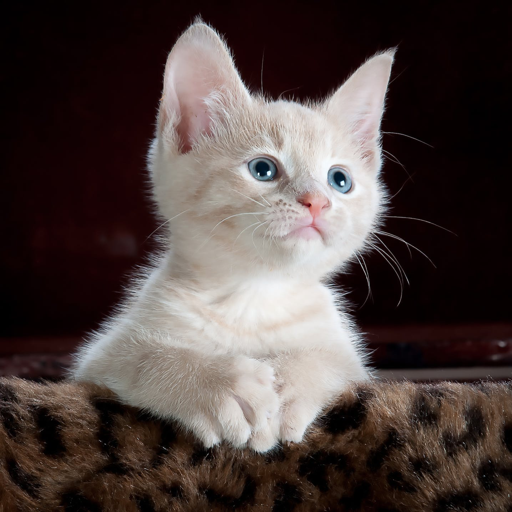

In [ ]:
p = FastDownload().download("https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2")
init_img = load_image(p)
init_img

In [ ]:
def get_noisy_pred(prompt, init_img, neg_prompt=None, g=7.5, strength =0.5, seed=100, steps=50, dim=512):
    if seed: torch.manual_seed(seed)
    scheduler.set_timesteps(steps)
    text = text_enc(prompt)
    uncond =  text_enc([""], text.shape[1])
    emb = torch.cat([uncond, text])
    init_latents = preprocess(init_img)
    
    init_timestep = int(steps * strength)
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device="cuda")
    noise = torch.randn(init_latents.shape, generator=None, device="cuda", dtype=init_latents.dtype)
    init_latents = scheduler.add_noise(init_latents, noise, timesteps)
    latents = init_latents
    
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timesteps)
    with torch.no_grad():
        u,t = unet(latent_model_input, timesteps, encoder_hidden_states=emb).sample.chunk(2)

    pred = u + g*(t - u)
    
    return scheduler.step(pred, timesteps, latents).pred_original_sample

def diff_to_mask(d, n, thres=0.5):
    mask = torch.zeros_like(d[0], dtype = d[0].dtype)
    for i in range(n):
        mask += d[i]
    mask = (mask / n)
    mask = (mask - mask.min()) / (mask.max()-mask.min()) >= thres
    mask  = np.round((mask.permute(1, 2, 0).numpy()))
    mask = mask.mean(axis=-1).astype("uint8")
    return mask

def make_mask(orig_p, targ_p, init_image, n=15, thres=0.5):
    diff0, diff1 = {}, {}
    for i in range(n):
        orig_noisy = get_noisy_pred(prompt= orig_p, init_img=init_image, seed=i*100)
        targ_noisy = get_noisy_pred(prompt= targ_p, init_img=init_image, seed=i*100)
        diff0[i] = latents_to_pil(orig_noisy-targ_noisy)[0].detach().cpu()
        diff1[i] = latents_to_pil(targ_noisy-orig_noisy)[0].detach().cpu()
    
    mask = np.minimum(1, diff_to_mask(diff0, n, thres=thres) + diff_to_mask(diff1, n, thres=thres))
    return mask

In [ ]:
mask = make_mask(
    orig_p=["a cat image"],
    targ_p = ["a dog image"],
    init_image = load_image(p),
    n = 30
)

In [ ]:
!ls

mask.jpeg  mask.pickle	sample_data


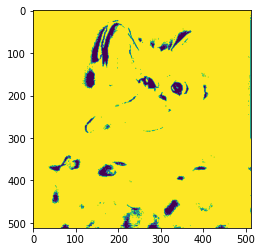

In [ ]:
plt.imshow(mask)

In [ ]:
plt.imsave('./mask.jpeg', mask, cmap='Greys')

In [ ]:
def improve_mask(p, mask):
    ## load image
    image = cv2.imread(p) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ## Adapative threshold
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 45, 0)    

    # Perform morphology
    se = np.ones((0,0), dtype='uint8')
    image_close = cv2.morphologyEx(image, cv2.MORPH_CLOSE, se)
    image_close = abs(image_close - 255)
    
    ## mix morph + image mask
    nmask = np.minimum(1.0,mask + image_close)
    nmask = abs(nmask - 255)
    
    ## adding the blur+clip trick
    nmask = abs((abs(cv2.blur(nmask, (10, 10)) - 255) > 0) * 255 - 255)
    
    return nmask

In [ ]:
nmask = improve_mask('./mask.jpeg', mask)

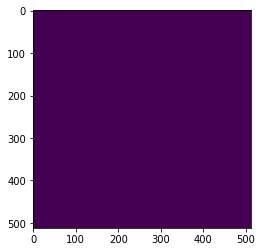

In [ ]:
plt.imshow(nmask)

In [ ]:
import pickle
with open('./mask.pickle', 'wb') as handle:
    pickle.dump(nmask, handle, protocol=pickle.HIGHEST_PROTOCOL)
plt.imsave('./mask.jpeg', nmask, cmap='Greys')

In [ ]:
del vae, unet, text_encoder, tokenizer, scheduler

Step 2 : Using inpaint pipeline

In [ ]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
).to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
image = pipe(
    prompt=["a dog image"], 
    image=load_image(p), 
    mask_image=load_image('./mask.jpeg'), 
    generator=torch.Generator("cuda").manual_seed(100),

).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

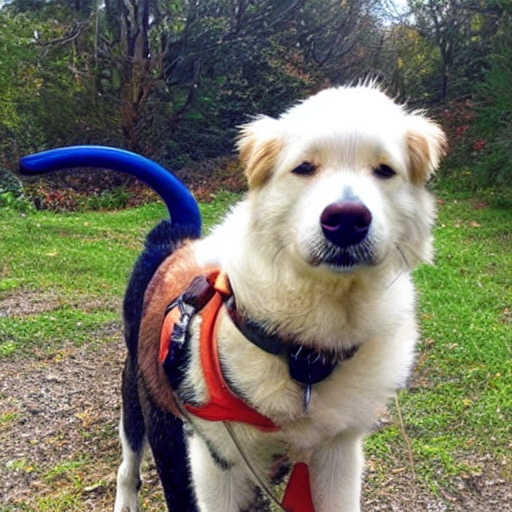

In [ ]:
image